In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import xgboost as xgb

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [4]:
def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [5]:
path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sampleSubmission.csv')

## Feature Engineering

In [6]:
train.weather.value_counts() # delete 4 from train data

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [7]:
test.weather.value_counts() # delete 4 from train data

1    4221
2    1710
3     560
4       2
Name: weather, dtype: int64

In [8]:
train = train[train['weather'] != 4]

In [9]:
all_data = pd.concat([train, test], ignore_index = True)
all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [10]:
all_data['datetime'] = pd.to_datetime(all_data['datetime']) #type casting
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday
all_data = all_data.drop(['datetime', 'casual', 'registered', 'windspeed', 'month'], axis = 1)

In [11]:
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

In [12]:
X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)

In [13]:
y = train['count']

## Data Visualization

Text(0.5, 1.0, 'Count Histplot')

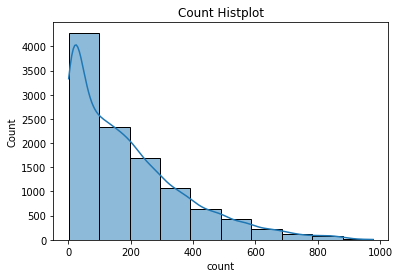

In [14]:
sns.histplot(y, bins=10, kde=True)
plt.title('Count Histplot')

<AxesSubplot:>

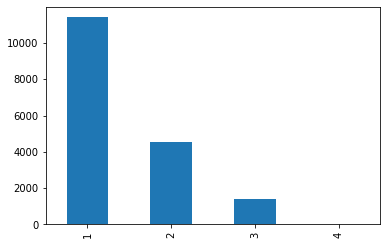

In [15]:
all_data.weather.value_counts().sort_values(ascending=False).plot.bar()

<AxesSubplot:>

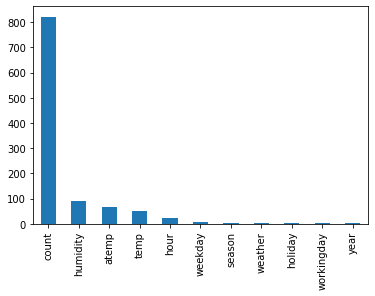

In [16]:
all_data.nunique().sort_values(ascending=False).plot.bar()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weekday', ylabel='count'>

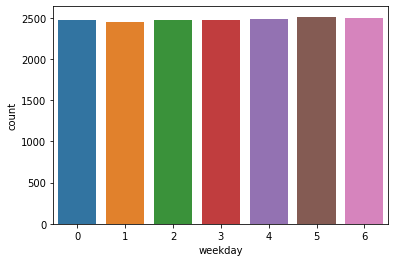

In [17]:
sns.countplot(all_data["weekday"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='humidity', ylabel='count'>

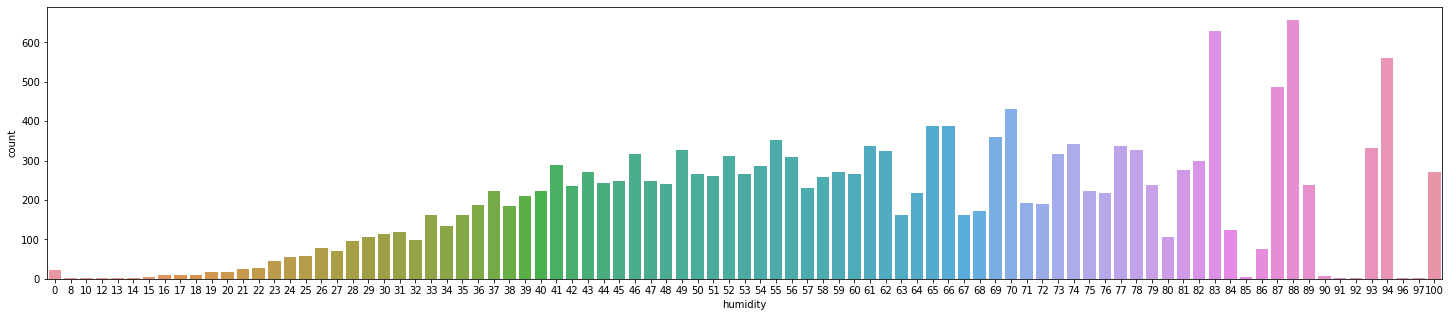

In [18]:
plt.figure(figsize=(25,5))
sns.countplot(all_data["humidity"])

## Training and Prediction

In [19]:
X_train

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5
...,...,...,...,...,...,...,...,...,...,...
10880,4,0,1,1,15.58,19.695,50,2012,19,2
10881,4,0,1,1,14.76,17.425,57,2012,20,2
10882,4,0,1,1,13.94,15.910,61,2012,21,2
10883,4,0,1,1,13.94,17.425,61,2012,22,2


In [20]:
X_train.nunique()

season         4
holiday        2
workingday     2
weather        3
temp          49
atemp         60
humidity      89
year           2
hour          24
weekday        7
dtype: int64

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10885 entries, 0 to 10884
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10885 non-null  int64  
 1   holiday     10885 non-null  int64  
 2   workingday  10885 non-null  int64  
 3   weather     10885 non-null  int64  
 4   temp        10885 non-null  float64
 5   atemp       10885 non-null  float64
 6   humidity    10885 non-null  int64  
 7   year        10885 non-null  int64  
 8   hour        10885 non-null  int64  
 9   weekday     10885 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 935.4 KB


In [22]:
log_y = np.log(y)
algo_test(X_train, log_y)

,R_Squared,RMSE,MAE
XGBRegressor,0.949981,0.336750,0.222864
Gradient Boosting,0.918863,0.428892,0.316020
Decision Tree,0.903991,0.466546,0.296203
Extra Tree,0.891767,0.495358,0.315056
KNeighborsRegressor,0.814817,0.647946,0.471948
Ridge,0.480760,1.084981,0.847973
Linear,0.480760,1.084982,0.847976
ElasticNet,0.439902,1.126861,0.880790
Lasso,0.428033,1.138737,0.889393


In [23]:
xgbr = xgb.XGBRegressor()
predictions = xgbr.fit(X_train, log_y).predict(X_test)
predictions

array([2.3665016, 1.525786 , 1.1924043, ..., 4.601906 , 4.4447975,
       3.7625809], dtype=float32)

In [24]:
submission['count'] = np.exp(predictions)
submission.to_csv('submission.csv', index = False)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.660033
1,2011-01-20 01:00:00,4.598757
2,2011-01-20 02:00:00,3.294994
3,2011-01-20 03:00:00,2.389372
4,2011-01-20 04:00:00,1.673502
